In [1]:
import torch
import numpy as np
import auction
import torch.nn as nn
import torch.nn.functional as F
import timeit
import sinkhorn
import matplotlib.pyplot as plt

In [2]:
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)

In [3]:
#distrib = torch.distributions.Exponential(torch.tensor([1.0]))
size_batch = (int)(10**5)
print(size_batch)
K=10
#y = torch.tensor([0.5, 1])
y = torch.linspace(1./K, 1., K) # discretization of uniform distribution
beta= torch.ones(K)/K
print(y)
print(beta)

100000
tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


In [4]:
net = auction.BidderStrategy(size_layer=200, nactions=12)

In [5]:
distrib = torch.distributions.Exponential(torch.tensor(1.))

In [6]:
input = torch.zeros((size_batch, 1),requires_grad=True)
samples = distrib.sample((size_batch, 1))
input.data = samples.clone()
print(input.size())

torch.Size([100000, 1])


In [7]:
time = timeit.default_timer()
C = auction.LazySecondPriceLoss(net, input, y, size_batch, distribution="exponential")
print('done in {0} s'.format(timeit.default_timer()-time))

done in 1.5087828299983812 s


# Sinkhorn

In [8]:
lamb = 0.05
niter_sink = 20
err_threshold = 1e-3

In [9]:
alpha, _ = net(input)

In [10]:
loss, gamma = sinkhorn.sinkhorn_loss_primal(alpha, C, beta, y, lamb, niter=niter_sink, cost="matrix", err_threshold=err_threshold, verbose=False)

In [11]:
print(alpha)
print()
print(torch.sum(gamma, dim=1))
print('--'*20)
print(beta)
print(torch.sum(gamma, dim=0))

tensor([0.0617, 0.0661, 0.0824, 0.1005, 0.1203, 0.0547, 0.1123, 0.0758, 0.0842,
        0.1035, 0.0722, 0.0662], grad_fn=<SoftmaxBackward>)

tensor([0.0618, 0.0662, 0.0825, 0.1005, 0.1203, 0.0547, 0.1122, 0.0758, 0.0842,
        0.1035, 0.0721, 0.0662], grad_fn=<SumBackward2>)
----------------------------------------
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], grad_fn=<SumBackward2>)


## Train network

In [12]:
net = auction.BidderStrategy(size_layer=200, nactions=12)
lamb = 0.01
niter_sink = 20
niter = 200
lr = 0.01
batch = 10000

In [13]:
loss_profile = auction.train_sinkhorn_auction(net, y, beta, lamb=lamb, niter_sink=niter_sink, max_iter=niter, 
                                              learning_rate=lr, err_threshold=1e-3, verbose=True, verbose_freq=100, size_batch=batch)

Loss at iterations 100: 0.6027765274047852
Loss at iterations 200: 0.48900431394577026
done in 56.339971711000544 s


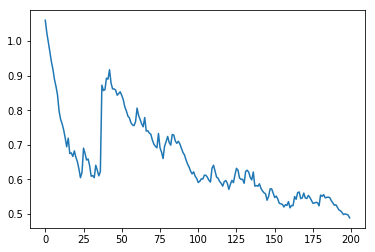

In [14]:
plt.plot(loss_profile)

In [15]:
loss, gamma, C = auction.eval(net, y, beta, lamb=lamb, niter_sink=100, size_batch=100000)

In [16]:
print('True loss:{}'.format(loss))
print('Utility loss:{}'.format(torch.sum(gamma*C)))
alpha = net.alpha()
print('Privacy loss:{}'.format(sinkhorn._KL(alpha, beta, gamma, epsilon=0)))

True loss:0.499358206987381
Utility loss:0.4953839182853699
Privacy loss:0.39746615290641785


# Test